## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.

Create 1 slide with informative visualization for each question. Explore data using SQL and Python but use Tableau for final visualization.

Don't limit your EDA to these 10 questions. Let's be creative :).

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
con = psycopg2.connect(database="mid_term_project", user="lhl_student", password="lhl_student", host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com", port="5432")

print("Database opened successfully")


Database opened successfully


In [3]:
def sql_execute(sql,con):
    cur = con.cursor()
    cur.execute(sql)
    print("Table created successfully")
    con.commit()
    con.close()

def sql_read(sql,con):
    return pd.read_sql(sql,con)

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [4]:
import scipy.stats as stats

In [54]:
weather_df=pd.read_csv('/Users/vikiggg/Desktop/local mid-term_project/pys/weather_data_complete.csv')
query='''
SELECT fl_date,origin_city_name,arr_delay FROM flights
LIMIT 10000
'''
flights_weather=sql_read(query,con)

In [55]:
#flights_weather=pd.read_csv('/Users/vikiggg/Desktop/LHL_Midterm/weather_data_task3.csv')
#flights_weather.drop('Unnamed: 0',axis=1,inplace=True)

In [56]:
flights_weather

,fl_date,origin_city_name,arr_delay,weather
0,2018-10-04,"Detroit, MI",-2.0,2
1,2018-06-30,"Indianapolis, IN",5.0,1
2,2018-11-19,"Nashville, TN",-7.0,1
3,2018-04-12,"Washington, DC",-5.0,0
4,2018-09-26,"Grand Junction, CO",54.0,1
...,...,...,...,...
99995,2019-11-23,"Denver, CO",3.0,0
99996,2019-07-23,"Philadelphia, PA",55.0,2
99997,2019-04-14,"Houston, TX",-4.0,0
99998,2018-07-23,"Seattle, WA",-26.0,0


In [57]:
def getWeather(date,city):
    weather=0
    if date=='2019-12-31':
        weather=0
    else:
        try:
            str=weather_df[weather_df['Date']==date][city].values[0]
        except:
            city=city[-2:]
            for i in weather_df.columns:
                if city in i:
                    city=i
                    break
            str=weather_df[weather_df['Date']==date][city].values[0]


        if 'Clear' in str:
            weather=0
        else:
            if 'Rain' in str:
                weather=2
            elif 'Snow' in str:
                weather=3
            else:
                weather=1
    return weather

In [58]:
weather_code=[]
for i in range(flights_weather.shape[0]):
    weather_code.append(getWeather(flights_weather['fl_date'][i],flights_weather['origin_city_name'][i]))

In [59]:
flights_weather['weather']=weather_code

In [60]:
flights_weather['weather'].value_counts()

1    37576
0    31448
2    28835
3     2141
Name: weather, dtype: int64

In [61]:
weather_delay=dict()
for i in set(weather_code):
    delay=flights_weather[flights_weather['weather']==i]['arr_delay']
    weather_delay[i]=delay

In [62]:
for i in set(weather_code):
    na_per=weather_delay[i].isnull().sum()/flights_weather.shape[0]
    print('in weather',{i},'the percent of null is',{na_per})
    weather_delay[i].dropna(inplace=True)

in weather {0} the percent of null is {0.00474}
in weather {1} the percent of null is {0.00501}
in weather {2} the percent of null is {0.00889}
in weather {3} the percent of null is {0.00126}


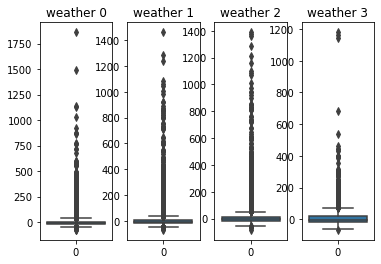

In [63]:
fig = plt.figure()

for i in set(weather_code):
    plt.subplot(1, len(set(weather_code)), i+1)
    sns.boxplot(data=weather_delay[i].values)
    plt.title(f'weather {i}')

plt.show()

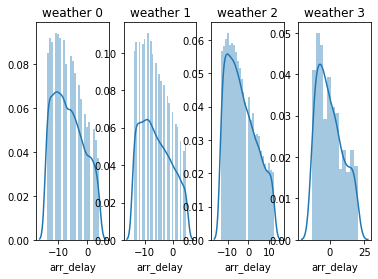

In [104]:
fig = plt.figure()

for i in set(weather_code):
    plt.subplot(1, len(set(weather_code)), i+1)
    sns.distplot(weather_delay[i])
    plt.title(f'weather {i}')

plt.show()

In [105]:
for i in set(weather_code):
    ll=np.percentile(weather_delay[i],25)
    hl=np.percentile(weather_delay[i],75)
    weather_delay[i]=weather_delay[i][(ll<weather_delay[i])&(weather_delay[i]<hl)]
    

In [65]:
for i in set(weather_code):
    stat,p=stats.shapiro(weather_delay[i])
    if p<0.05:
        print(f'arr_delay is normal distributed in {i} weather')
    else:
        print('not_distributed')

arr_delay is normal distributed in 0 weather
arr_delay is normal distributed in 1 weather
arr_delay is normal distributed in 2 weather
arr_delay is normal distributed in 3 weather


In [67]:
for i in set(weather_code):
    flights_weather[i]=0
    flights_weather[i].loc[flights_weather['weather']==i]=weather_delay[i]

In [74]:
import datetime
flights_weather['year'] = pd.DatetimeIndex(flights_weather['fl_date']).year
flights_weather['month'] = pd.DatetimeIndex(flights_weather['fl_date']).month
flights_weather['day'] = pd.DatetimeIndex(flights_weather['fl_date']).day
flights_weather=flights_weather.drop('fl_date',axis=1)

In [77]:
delay_by_month=flights_weather.groupby('month').sum()
delay_by_month

,arr_delay,weather,0,1,2,3,year,day
month,,,,,,,,
1,-17309.0,3495,-7804.0,-6709.0,-2631.0,-165.0,6941659,55460
2,-14355.0,3807,-4966.0,-5959.0,-3784.0,354.0,6384529,46103
3,-20327.0,3987,-8876.0,-8622.0,-2937.0,108.0,8181050,67430
4,-20475.0,3594,-8795.0,-8312.0,-3312.0,-56.0,7890345,60606
5,-20249.0,4296,-6760.0,-9796.0,-3701.0,8.0,8136543,63822
6,-20054.0,4235,-6434.0,-9656.0,-3964.0,0.0,8027542,61962
7,-22473.0,3924,-8735.0,-9949.0,-3789.0,0.0,8509986,67378
8,-21153.0,3932,-8110.0,-9319.0,-3724.0,0.0,8235509,65712
9,-22089.0,3698,-8326.0,-10329.0,-3434.0,0.0,7888274,62427


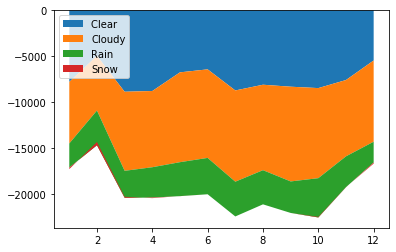

In [78]:
labels = ["Clear ", "Cloudy", "Rain","Snow"]
plt.stackplot(delay_by_month.index, delay_by_month[0],delay_by_month[1],delay_by_month[2],delay_by_month[3],labels=labels)
plt.legend(loc='upper left')
plt.show()

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [45]:
query='''
SELECT wheels_off,air_time FROM flights
'''

#haul_flight=sql_read(query,con)
#haul_flight.to_csv(r'/Users/vikiggg/Google/LHL/midterm/haulflights.csv')
haul_flight=pd.read_csv('/Users/vikiggg/Google/LHL/midterm/haulflights.csv')

In [97]:
haul_flight=haul_flight.dropna()
haul_flight.isnull().any()

wheels_off    False
air_time      False
dtype: bool

In [98]:
haul_flight['category'] = np.where(haul_flight['air_time']<180,'SHORT','MEDIUM')
haul_flight.loc[haul_flight['air_time']>360,'category'] = 'LONG'

In [143]:
haul_flight.category.value_counts()

SHORT     13507359
MEDIUM     2047641
LONG         57264
Name: category, dtype: int64

In [99]:
hours=[]
for i in haul_flight['wheels_off']:
    hours.append(int(i/100))
haul_flight['take_off_hr']=hours
haul_flight

,wheels_off,air_time,category,take_off_hr
0,1941.0,33.0,SHORT,19
1,1709.0,95.0,SHORT,17
2,2222.0,42.0,SHORT,22
3,1611.0,58.0,SHORT,16
4,1816.0,52.0,SHORT,18
...,...,...,...,...
15927480,830.0,93.0,SHORT,8
15927481,922.0,40.0,SHORT,9
15927482,1437.0,39.0,SHORT,14
15927483,1120.0,77.0,SHORT,11


In [109]:
def getMode(cat):
    mode_hr=haul_flight[haul_flight['category']==cat]['take_off_hr'].mode()[0]
    total_flights=haul_flight[haul_flight['category']==cat]['take_off_hr'].count()
    print ('for',cat,'haul flights,','at',mode_hr,'o\'clock has the most flights, which is in total ',total_flights)

In [110]:
getMode('SHORT')
getMode('MEDIUM')
getMode('LONG')

for SHORT haul flights, at 6 o'clock has the most flights, which is in total  13507359
for MEDIUM haul flights, at 7 o'clock has the most flights, which is in total  2047641
for LONG haul flights, at 11 o'clock has the most flights, which is in total  57264


In [101]:
#haul_flight=haul_flight.drop('Unnamed: 0',axis=1)
haul_flight

,wheels_off,air_time,category,take_off_hr
0,1941.0,33.0,SHORT,19
1,1709.0,95.0,SHORT,17
2,2222.0,42.0,SHORT,22
3,1611.0,58.0,SHORT,16
4,1816.0,52.0,SHORT,18
...,...,...,...,...
15927480,830.0,93.0,SHORT,8
15927481,922.0,40.0,SHORT,9
15927482,1437.0,39.0,SHORT,14
15927483,1120.0,77.0,SHORT,11


In [136]:
#short_haul_fl=haul_flight[haul_flight['category']=='LONG']['take_off_hr']
#short_haul_fl.to_csv('/Users/vikiggg/Google/LHL/midterm/long_haul_fl.csv')

(array([ 45458.,  22205.,   5885.,   3318.,   3538., 266345., 900422.,
        825983., 801525., 775110., 839098., 830080., 852252., 782512.,
        790126., 816151., 775270., 816162., 809258., 734562., 739790.,
        496799., 428315., 147195.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 24 Patch objects>)

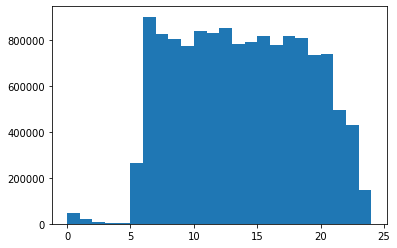

In [140]:
plt.hist(haul_flight[haul_flight['category']=='SHORT']['take_off_hr'],bins=24)

(array([ 41146.,  14654.,   4548.,   1910.,   1197.,  20463., 114262.,
        157971., 154875., 123103., 124684., 116689., 116728., 106759.,
        108530.,  97624., 104961., 114548., 112960.,  93132.,  86311.,
         81951.,  78430.,  70205.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 24 Patch objects>)

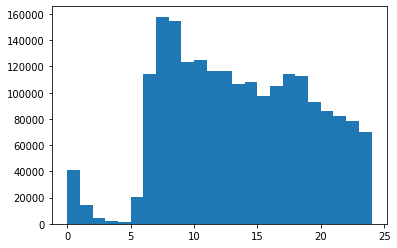

In [141]:
plt.hist(haul_flight[haul_flight['category']=='MEDIUM']['take_off_hr'],bins=24)

(array([1.370e+02, 1.940e+02, 9.800e+01, 6.000e+00, 4.000e+00, 3.500e+01,
        1.429e+03, 4.164e+03, 3.201e+03, 4.169e+03, 5.443e+03, 6.256e+03,
        2.858e+03, 6.130e+02, 1.550e+03, 3.269e+03, 4.621e+03, 4.509e+03,
        4.455e+03, 3.482e+03, 3.963e+03, 1.881e+03, 6.550e+02, 2.720e+02]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <a list of 24 Patch objects>)

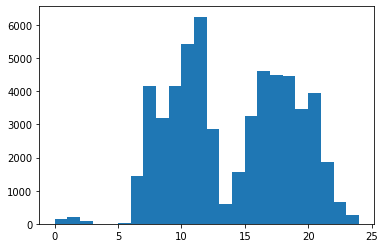

In [142]:
plt.hist(haul_flight[haul_flight['category']=='LONG']['take_off_hr'],bins=24)

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [106]:
query='''
SELECT LEFT(fl_date,4) AS fl_year, 
origin_airport_id,origin_city_name,
dest_airport_id,dest_city_name
FROM flights
ORDER BY arr_delay
'''
#flight_traffic=sql_read(query,con)
flight_traffic=pd.read_csv(r'/Users/vikiggg/Desktop/LHL_Midterm/flights_traffic.csv')
flight_traffic

,Unnamed: 0,fl_year,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name
0,0,2018,14747,"Seattle, WA",14252,"Pasco/Kennewick/Richland, WA"
1,1,2018,13487,"Minneapolis, MN",15016,"St. Louis, MO"
2,2,2018,14747,"Seattle, WA",14908,"Santa Ana, CA"
3,3,2018,11433,"Detroit, MI",10599,"Birmingham, AL"
4,4,2018,14747,"Seattle, WA",14679,"San Diego, CA"
...,...,...,...,...,...,...
8459995,8459995,2019,14122,"Pittsburgh, PA",13204,"Orlando, FL"
8459996,8459996,2019,13495,"New Orleans, LA",13303,"Miami, FL"
8459997,8459997,2019,11298,"Dallas/Fort Worth, TX",13851,"Oklahoma City, OK"
8459998,8459998,2019,11298,"Dallas/Fort Worth, TX",15304,"Tampa, FL"


In [127]:
flight_traffic.drop('Unnamed: 0',axis=1,inplace=True)

In [132]:
def getFlightTraffic(year):
    #year=str(year)
    traffic_out=flight_traffic[flight_traffic['fl_year']==year].groupby('origin_airport_id').count()['fl_year']
    traffic_in=flight_traffic[flight_traffic['fl_year']==year].groupby('dest_airport_id').count()['fl_year']
    flight_traffic_total=pd.concat([traffic_out,traffic_in],axis=0,join='outer').rename_axis('airport').groupby('airport').sum()
    col1=pd.DataFrame(data=flight_traffic_total.index, columns=['airport'])
    col2=pd.DataFrame(data=flight_traffic_total.values, columns=[f'flights_{year}'])
    return pd.merge(col1, col2, left_index=True, right_index=True)

In [133]:
getFlightTraffic(2018)

,airport,flights_2018
0,10135,5707
1,10136,1942
2,10140,28863
3,10141,915
4,10146,1010
...,...,...
365,15897,155
366,15919,14733
367,15991,917
368,16101,1028


In [108]:
passenger_query='''
SELECT passengers,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,year FROM passengers
WHERE origin_country='US' AND dest_country='US' AND year>=2018
ORDER BY payload
'''

#passenger_traffic=sql_read(passenger_query,con)
passenger_traffic=pd.read_csv(r'/Users/vikiggg/Desktop/LHL_Midterm/pax_traffic.csv')
passenger_traffic

,Unnamed: 0,passengers,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,year
0,0,0.0,15096,"Syracuse, NY",12397,"Ithaca/Cortland, NY",2019
1,1,0.0,10434,"Scranton/Wilkes-Barre, PA",11618,"Newark, NJ",2019
2,2,0.0,10397,"Atlanta, GA",14635,"Fort Myers, FL",2019
3,3,0.0,11066,"Columbus, OH",10397,"Atlanta, GA",2019
4,4,0.0,13485,"Madison, WI",13342,"Milwaukee, WI",2019
...,...,...,...,...,...,...,...
775424,775424,0.0,12266,"Houston, TX",14730,"Louisville, KY",2019
775425,775425,0.0,10299,"Anchorage, AK",13930,"Chicago, IL",2019
775426,775426,0.0,10299,"Anchorage, AK",13930,"Chicago, IL",2019
775427,775427,79434.0,12173,"Honolulu, HI",13830,"Kahului, HI",2018


In [109]:
passenger_traffic

,Unnamed: 0,passengers,origin_airport_id,origin_city_name,dest_airport_id,dest_city_name,year
0,0,0.0,15096,"Syracuse, NY",12397,"Ithaca/Cortland, NY",2019
1,1,0.0,10434,"Scranton/Wilkes-Barre, PA",11618,"Newark, NJ",2019
2,2,0.0,10397,"Atlanta, GA",14635,"Fort Myers, FL",2019
3,3,0.0,11066,"Columbus, OH",10397,"Atlanta, GA",2019
4,4,0.0,13485,"Madison, WI",13342,"Milwaukee, WI",2019
...,...,...,...,...,...,...,...
775424,775424,0.0,12266,"Houston, TX",14730,"Louisville, KY",2019
775425,775425,0.0,10299,"Anchorage, AK",13930,"Chicago, IL",2019
775426,775426,0.0,10299,"Anchorage, AK",13930,"Chicago, IL",2019
775427,775427,79434.0,12173,"Honolulu, HI",13830,"Kahului, HI",2018


In [110]:
def getPax(year):
    pax_traffic_out=(passenger_traffic[passenger_traffic['year']==year].groupby('origin_airport_id').sum())['passengers']
    pax_traffic_in=(passenger_traffic[passenger_traffic['year']==year].groupby('dest_airport_id').sum())['passengers']
    pax=pd.concat([pax_traffic_out,pax_traffic_in],axis=0,join='outer').rename_axis('airport').groupby('airport').sum()
    col1=pd.DataFrame(data=pax.index, columns=['airport'])
    col2=pd.DataFrame(data=pax.values, columns=[f'pax_{year}'])
    return pd.merge(col1, col2, left_index=True, right_index=True)

In [120]:
getPax(2018)

,airport,pax_2018
0,10005,479.0
1,10006,8.0
2,10009,13.0
3,10010,3.0
4,10011,55815.0
...,...,...
1335,16829,8.0
1336,16837,147.0
1337,16838,14.0
1338,16839,6.0


In [ ]:
# generate an airport<>id dictionary
airport_dict={}
for i in range(flight_traffic.shape[0]):
    airport_dict[flight_traffic['origin_airport_id'][i]]=flight_traffic['origin_city_name'][i]

for i in range(flight_traffic.shape[0]):
    airport_dict[flight_traffic['dest_airport_id'][i]]=flight_traffic['dest_city_name'][i]

for i in range(passenger_traffic.shape[0]):
    airport_dict[passenger_traffic['origin_airport_id'][i]]=passenger_traffic['origin_city_name'][i]

for i in range(passenger_traffic.shape[0]):
    airport_dict[passenger_traffic['dest_airport_id'][i]]=passenger_traffic['dest_city_name'][i]

len(airport_dict.keys()) #-->1515

In [117]:
airport_id=pd.read_csv('/Users/vikiggg/Google/airport_id.csv')
airport_id=airport_id.rename({'index':'airport',0:'city'},axis=1)
airport_id=airport_id.set_index('airport')
airport_dict=airport_id.to_dict(orient='index')
#airport_dict

In [ ]:
def compare_airport(year):

    compare_table=pd.merge(getFlightTraffic(year),getPax(year),how='outer',on='airport').set_index('airport').sort_values(f'flights_{year}',ascending=False)

    # normalized
    scaller = StandardScaler()
    value_std = scaller.fit_transform(compare_table[[f'flights_{year}',f'pax_{year}']])
    compare_table[[f'flights_{year}',f'pax_{year}']]=value_std
    compare_table

    #add city name
    city=[]
    for i in range(compare_table.shape[0]):
        city.append(airport_dict[(compare_table.index)[i]]['city'])
    compare_table['city']=city

    compare_table['indicator']=compare_table[f'flights_{year}']*compare_table[f'pax_{year}']
    
    return compare_table.sort_values(by='indicator',ascending=False)


In [137]:
compare_airport(2018).head(10)

,flights_2018,pax_2018,city,indicator
airport,,,,
10397,7.817419,15.103131,"Atlanta, GA",118.067497
13930,6.776192,10.841102,"Chicago, IL",73.461386
11292,4.922389,9.827114,"Denver, CO",48.372877
12892,4.786416,9.845603,"Los Angeles, CA",47.125150
11298,4.684554,9.338633,"Dallas/Fort Worth, TX",43.747325
11057,4.041986,6.702181,"Charlotte, NC",27.090121
14747,3.095162,6.919886,"Seattle, WA",21.418168
14771,2.978906,6.802040,"San Francisco, CA",20.262638
12889,2.753815,7.172488,"Las Vegas, NV",19.751706


In [138]:
compare_airport(2019).head(10)

,flights_2019,pax_2019,city,indicator
airport,,,,
10397,8.064333,15.035454,"Atlanta, GA",121.250896
13930,6.779635,10.719602,"Chicago, IL",72.674990
11292,4.770040,10.137535,"Denver, CO",48.356449
11298,4.830958,9.797141,"Dallas/Fort Worth, TX",47.329576
12892,4.539985,9.590666,"Los Angeles, CA",43.541481
11057,4.418078,6.992674,"Charlotte, NC",30.894178
14747,3.112390,6.923861,"Seattle, WA",21.549752
12889,2.765495,7.162148,"Las Vegas, NV",19.806884
14107,2.948320,6.702744,"Phoenix, AZ",19.761832


## **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?